<a href="https://colab.research.google.com/github/DragonFarts/Video-EZY/blob/main/Demo_of_VideoEZY_v0_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

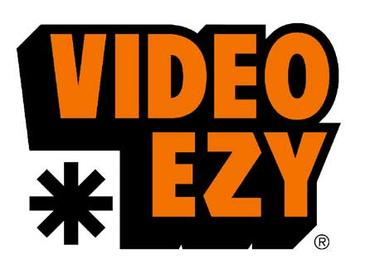

**Demo of the VideoEzy v0.02**

I will be bringing back all the features and more of VideoEzy into this.
This code is much cleaner and easier to manage for me.


1.   Write your script
2.   Install the requirements
3.   Generate your video

your video will appear in

/content/final_video.mp4



# write your shit

In [32]:
%%writefile script.txt
--text
daniel Narrator "Space Cats! Space is for the place that surrounds us"
daniel Narrator "and cat stands for  Cats Adventuring Through Space"
daniel Narrator "For a long time Planet Earth has been out of tuna so the Space Cats must adventure off into the universe to obtain some"
daniel Narrator "To the Space Cats Tuna is worth more than gold so look out if your holding a can of yummy stinky tuna fish"
--genvid
"Space Cats Movie Title" 2
"a cat in the captains chair of a spaceship, hd, high quality" 2
"Cats working like engineers inside of a spaceship, hd, high quality" 2
"Cat shaped Spaceships having a star fight, hd, high quality" 1
"Cats inside of a spaceship dancing, hd, high quality" 2
"Cats eating tuna fish inside of a spaceship, hd, high quality" 2
--sfxgen  "a psychedelic rock song musical composition for space movie"
--sfxgen  "a happy cat meowing"
--sfxgen  "A spaceship flying pass"
--sfxgen  "Space Ships shooting lazers at eachother"
--makevid
temp1 12 temp2 12 temp3 6 temp4 6 temp5 6 temp6 6 temp7 6 temp8 6 temp9 6 temp10 6 temp11 6 temp1 12 temp2 12 temp10 6 temp11 6
--addtxt
"SPACE CATS!"
--dubvid
wav1 0 wav2 0 wav3 0 wav4 0
sfx2 4 sfx3 5 sfx4 5 sfx2 4
sfx1 0 sfx1 0 sfx1 0 sfx1 0

Overwriting script.txt


# install the crap

In [4]:
!mkdir -p /content/fonts/ && wget -O /content/fonts/FFF_Tusj.ttf https://github.com/DragonFarts/Video-EZY/raw/main/FFF_Tusj.ttf

--2023-10-08 21:05:08--  https://github.com/DragonFarts/Video-EZY/raw/main/FFF_Tusj.ttf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DragonFarts/Video-EZY/main/FFF_Tusj.ttf [following]
--2023-10-08 21:05:09--  https://raw.githubusercontent.com/DragonFarts/Video-EZY/main/FFF_Tusj.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1543648 (1.5M) [application/octet-stream]
Saving to: ‘/content/fonts/FFF_Tusj.ttf’

/content/fonts/FFF_ 100%[===================>]   1.47M  --.-KB/s    in 0.01s   

2023-10-08 21:05:09 (148 MB/s) - ‘/content/fonts/FFF_Tusj.ttf’ saved [1543648/1543648]



In [5]:
!pip install pydub

In [6]:
%cd /content/

/content


In [36]:

%%writefile VideoEzy.py
import subprocess
import argparse
import os
import shutil
import random
import glob
import cv2
import copy
import gc  # Import the garbage collection module

from PIL import Image, ImageDraw, ImageFont

import numpy as np
sfxcount = 0  # Initialize your sfx count variable
output_directory = "/content/out/"
# Ensure that the output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
from moviepy.audio.fx.all import volumex
from moviepy.audio.AudioClip import AudioArrayClip

from moviepy.editor import AudioFileClip, CompositeAudioClip
from moviepy.editor import TextClip, CompositeVideoClip, VideoFileClip, concatenate_videoclips, concatenate_audioclips
from moviepy.video.fx import time_mirror
from moviepy.editor import ImageSequenceClip
from pydub import AudioSegment
from moviepy.audio.AudioClip import AudioArrayClip

def run_testpy_script(rvc_voice, wav_file_path, output_file_path):
    subprocess.run([
        "python",
        "/content/test.py",
        "--name", rvc_voice,  # Only rvc_voice is passed here
        "--f0_up_key", "0",
        "--input_path", wav_file_path,
        "--out", output_file_path
    ])


def overlay_text_on_video(video_path, text, output_path):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            pil_im = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            draw = ImageDraw.Draw(pil_im)

            # Define a larger font size and get a suitable font
            font_size = 48
            font = ImageFont.truetype("/content/fonts/FFF_Tusj.ttf", font_size)

            # Calculate text size and position to center it
            text_width, text_height = draw.textsize(text, font=font)
            frame_width, frame_height = pil_im.size
            text_x = (frame_width - text_width) // 2
            text_y = (frame_height - text_height) // 2

            draw.text((text_x, text_y), text, font=font, fill=(255, 255, 255))

            frame = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)
            out.write(frame)
        else:
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

def overlay_audio_arrays(array1, array2):
    # Make sure both arrays have the same shape
    length_diff = len(array1) - len(array2)
    if length_diff > 0:
        array2 = np.pad(array2, [(0, length_diff), (0, 0)], 'constant')
    elif length_diff < 0:
        array1 = np.pad(array1, [(0, -length_diff), (0, 0)], 'constant')

    # Overlay the audio
    return array1 + array2


def combine_audio_files(dubvid_info, index):
    combined_audio = AudioSegment.empty()
    for wav, silence in zip(dubvid_info[::2], dubvid_info[1::2]):
        audio = AudioSegment.from_wav(f"/content/out/{wav}.wav")
        combined_audio += audio + AudioSegment.silent(duration=int(float(silence) * 1000))
    combined_audio.export(f"/content/combined_audio_{index}.wav", format="wav")
    return combined_audio


def make_video(gif_loop_info, output_path):
    clips = []
    for gif, loops in zip(gif_loop_info[::2], gif_loop_info[1::2]):
        clip = VideoFileClip(f"/content/Hotshot-XL/{gif}.gif")
        clips.extend([clip] * int(loops))

    try:
        final_clip = concatenate_videoclips(clips)
        final_clip.write_videofile(output_path)
    except IndexError:
        print("IndexError: One of the clips is too short for the concatenation.")


def reverse_and_append_gif(gif_path):
    clip = VideoFileClip(gif_path)
    reversed_clip = time_mirror.time_mirror(clip)
    final_clip = concatenate_videoclips([clip, reversed_clip])
    final_clip.write_gif(gif_path)

def read_arguments_from_file(file_path):
    args = {}
    current_key = None
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("--"):
                current_key = line.split()[0]
                args[current_key] = []
            else:
                args[current_key].append(line)
    return args





def find_and_copy_wav_file(src_dir="/content/temp/", dest_dir="/content/temp/"):
    for filename in os.listdir(src_dir):
        if filename.endswith(".wav"):
            src_path = os.path.join(src_dir, filename)
            wav_num = 1
            dest_filename = f"wav{wav_num}.wav"
            dest_path = os.path.join(dest_dir, dest_filename)

            while os.path.exists(dest_path):
                wav_num += 1
                dest_filename = f"wav{wav_num}.wav"
                dest_path = os.path.join(dest_dir, dest_filename)

            shutil.copy(src_path, dest_path)
            break



def main(voice_texts, genvids, makevid_info, dubvid_infos, sfxgen, addtxt):
    os.chdir("/content")
    global sfxcount  # Declare sfxcount as a global variable within the function

    with open("/content/script.txt", "r") as f:
        lines = f.readlines()

    sfx_args = [line.split('--sfxgen ')[1].strip().strip('"') for line in lines if '--sfxgen' in line]


    for sfxgen in sfx_args:
        if sfxgen:
            subprocess.run([
                'audioldm2', '-t', sfxgen, '--model_name', 'audioldm_48k', '--save_path', '/content/sfxout'
            ])

            # Assuming the new file is saved in a timestamped folder under /content/sfxout
            newest_subfolder = max(glob.glob(os.path.join('/content/sfxout', '*/')), key=os.path.getmtime)

            # Assuming there's only one wav file in the timestamped subfolder
            wav_file = glob.glob(os.path.join(newest_subfolder, '*.wav'))[0]

            sfxcount += 1
            new_file_path = os.path.join('/content/out', f"sfx{sfxcount}.wav")

            shutil.copy(wav_file, new_file_path)

    if genvids:

        # First clone and setup Hotshot-XL
        subprocess.run(["pip", "uninstall", "-y", "torch", "torchvision", "torchaudio"])
        subprocess.run(["pip", "install", "torch==2.0.1", "torchvision==0.15.2", "torchaudio==2.0.2", "-f", "https://download.pytorch.org/whl/cu111/torch_stable.html"])
        subprocess.run(["pip", "uninstall", "-y", "transformers"])
        subprocess.run(["pip", "install", "transformers>=4.33.3"])
        subprocess.run(["git", "clone", "-b", "dev", "https://github.com/camenduru/Hotshot-XL"])
        os.chdir("/content/Hotshot-XL")
        subprocess.run(["pip", "install", "-q", "accelerate"])
        subprocess.run(["pip", "install", "-q", "."])



        # Initialize counter before entering loop
        counter = 1

        # Generate GIFs
        for genvid, num_gifs in genvids:
            for i in range(1, int(num_gifs) + 1):
                output_filename = f"temp{counter}.gif"
                # Generate a random seed
                random_seed = random.randint(-10000, 10000)  # You can set the range as per your needs
                subprocess.run(["python", "inference.py", f"--seed={random_seed}", "--prompt", genvid, "--output", output_filename])

                # Reverse and append to each of the GIFs
                reverse_and_append_gif(output_filename)

                # Increment the counter
                counter += 1


        os.chdir("/content")
        # Install moviepy (if not already installed)
        subprocess.run(["pip", "install", "moviepy"])

    if voice_texts:
        # Now setup and run tortoise-hf
        subprocess.run(["pip", "uninstall", "-y", "torch", "torchvision", "torchaudio"])
        subprocess.run(["pip", "install", "torch", "torchvision", "torchaudio", "-f", "https://download.pytorch.org/whl/cu111/torch_stable.html"])
        subprocess.run(["git", "clone", "-b", "dev", "https://github.com/camenduru/tortoise-hf"])
        os.chdir("/content/tortoise-hf")
        subprocess.run(["git", "clone", "-b", "v1.0", "https://github.com/camenduru/tortoise-tts"])
        subprocess.run(["pip", "install", "gradio", "scipy", "-U"])
        os.chdir("/content/tortoise-hf/tortoise-tts")
        subprocess.run(["pip", "uninstall", "-y", "transformers"])
        subprocess.run(["pip", "install", "transformers==4.19.0"])
        subprocess.run(["pip", "install", "-r", "requirements.txt"])
        subprocess.run(["python", "setup.py", "install"])

        move_wav_counter = 1

        wav_counter = 1  # Initialize counter for wav files
        for voice, rvc_voice, text in voice_texts:


            subprocess.run(["python3", "/content/tortoise-hf/tortoise-tts/tortoise/do_tts.py", "--text", text, "--voice", voice, "--preset", "high_quality", "--output", "/content/TempAudio", "--candidates", "1"])
            find_and_copy_wav_file("/content/TempAudio", "/content/temp")
            wav_file_path = f"/content/temp/wav{wav_counter}.wav"
            output_file_path = f"/content/temp/wav{wav_counter}_temp.wav"

            if rvc_voice != 'none':
                os.chdir("/content/")
                run_testpy_script(rvc_voice, wav_file_path, output_file_path)
                os.rename(output_file_path, wav_file_path)
                os.chdir("/content/tortoise-hf/tortoise-tts")

            # After all operations are done on the current wav_file
            while os.path.exists(f"/content/out/wav{move_wav_counter}.wav"):
                move_wav_counter += 1

            shutil.move(wav_file_path, f"/content/out/wav{move_wav_counter}.wav")




    if makevid_info:
        make_video(makevid_info, "/content/output_video.mp4")

    if addtxt:
        overlay_text_on_video("/content/output_video.mp4", addtxt, "/content/output_video_with_text.mp4")
        shutil.copy("/content/output_video_with_text.mp4", "/content/output_video.mp4")






















    if dubvid_infos:
        video = VideoFileClip("/content/output_video.mp4")
        original_audio = video.audio

        if original_audio is None:
            blank_audio = AudioArrayClip(np.zeros((int(video.duration * 44100), 2)), fps=44100)
            original_audio = blank_audio.set_duration(video.duration)

        combined_audio_list = []
        volume_multiplier = 1.0  # Initial volume level for the first dub

        for i, dubvid_info in enumerate(dubvid_infos):
            combine_audio_files(dubvid_info, i)
            new_audio = AudioFileClip(f"/content/combined_audio_{i}.wav")
            new_audio = new_audio.volumex(volume_multiplier)  # Adjust the volume
            combined_audio_list.append(new_audio)
            volume_multiplier *= 0.7  # Reduce volume by 30% for the next dub

        final_audio_clips = [original_audio] + combined_audio_list

        print("Final audio clips list: ", final_audio_clips)  # Debug print

        final_combined_audio = CompositeAudioClip(final_audio_clips)

        final_video = video.set_audio(final_combined_audio)
        final_video.write_videofile("/content/final_video.mp4", audio_codec='aac')




if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    args_dict = read_arguments_from_file('script.txt')

    voice_texts = [(x.split()[0], x.split()[1], " ".join(x.split()[2:])) for x in args_dict.get('--text', [])]

    genvids = [(x.rsplit(' ', 1)[0], x.rsplit(' ', 1)[1]) for x in args_dict.get('--genvid', [])]
    makevid_info = args_dict.get('--makevid', [])[0].split() if args_dict.get('--makevid', []) else None
    sfxgen = args_dict.get('--sfxgen', [])[0] if args_dict.get('--sfxgen', []) else None
    dubvid_infos = []
    if '--dubvid' in args_dict:
        for line in args_dict['--dubvid']:
            dubvid_infos.append(line.split())
    # Add the argument for overlaying text
    addtxt = args_dict.get('--addtxt', [])[0] if args_dict.get('--addtxt', []) else None

    main(voice_texts, genvids, makevid_info, dubvid_infos, sfxgen, addtxt)

Overwriting VideoEzy.py


**RVC**

In [8]:
%cd /content/
!pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121
!pip install pyttsx3
!pip install sounddevice
!pip install soundfile
!sudo apt-get update
!sudo apt-get install aria2
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/hubert_base.pt -d /content/ -o hubert_base.pt
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/rmvpe.pt -d /content/ -o rmvpe.pt
!pip install -e git+https://github.com/JarodMica/rvc.git#egg=rvc
!pip install -e git+https://github.com/JarodMica/rvc-tts-pipeline.git#egg=rvc_tts_pipe
import sys
sys.path.append('/content/src/rvc')
sys.path.append('/content/src/rvc-tts-pipe')

/content
Looking in indexes: https://download.pytorch.org/whl/nightly/cu121
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,342 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,266 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/u

In [9]:
from rvc_infer import rvc_convert

In [10]:
%%writefile test.py
import argparse
import os
import time
import shutil
import glob
from rvc_infer import rvc_convert

def find_paths(keyword, base_folder):
    for root, dirs, files in os.walk(base_folder):
        if keyword in root:
            index_files = glob.glob(os.path.join(root, '*.index'))
            pth_files = glob.glob(os.path.join(root, '*.pth'))
            if index_files and pth_files:
                return pth_files[0], index_files[0]
    return None, None

def copy_output_file(src, dest):
    try:
        shutil.copy(src, dest)
        print(f"File copied from {src} to {dest}")
    except Exception as e:
        print(f"An error occurred while copying: {e}")

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--name", required=True)
    parser.add_argument("--f0_up_key", required=True)
    parser.add_argument("--input_path", required=True)
    parser.add_argument("--out", required=True)
    args = parser.parse_args()

    base_folder = '/content/#voicervc/'

    model_path, file_index = find_paths(args.name, base_folder)

    if model_path and file_index:
        # Call rvc_convert function
        rvc_convert(model_path=model_path, file_index=file_index, f0_up_key=int(args.f0_up_key), input_path=args.input_path)

        # Wait for 0.25 seconds to ensure the output file is ready
        time.sleep(0.25)

        # Copy file
        default_output_path = "/content/output/out.wav"
        copy_output_file(default_output_path, args.out)
    else:
        print(f"No matching .pth and .index files found for {args.name} in {base_folder}")


Writing test.py


In [11]:
%%writefile RVC-dl.py
import requests
import zipfile
import io
import os
import sys
import re
import gdown
import time



def resolve_hugging_face_url(zip_url):
    response = requests.head(zip_url, allow_redirects=True)
    if response.status_code == 200:
        return response.url
    else:
        return None

def extract_google_drive(file_id, target_directory):
    temp_zip_path = "/content/temp_google_drive.zip"
    gdown.download(f"https://drive.google.com/uc?id={file_id}", temp_zip_path, quiet=False)

    with zipfile.ZipFile(temp_zip_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            if not file_info.is_dir():  # Only extract files
                file_info.filename = os.path.basename(file_info.filename)
                zip_ref.extract(file_info, target_directory)

    os.remove(temp_zip_path)
    print("ZIP file downloaded and extracted successfully from Google Drive.")

def extract_zip(zip_url, target_directory):
    os.makedirs(target_directory, exist_ok=True)

    if "drive.google.com" in zip_url:
        file_id_search = re.search(r"/file/d/([a-zA-Z0-9_-]+)/", zip_url)
        if file_id_search:
            file_id = file_id_search.group(1)
            extract_google_drive(file_id, target_directory)
        else:
            print("Invalid Google Drive URL.")
        return

    if "huggingface.co" in zip_url:
        zip_url = resolve_hugging_face_url(zip_url)
        if zip_url is None:
            print("Failed to resolve Hugging Face URL.")
            return

    response = requests.get(zip_url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
            for file_info in zip_ref.infolist():
                if not file_info.is_dir():  # Only extract files
                    file_info.filename = os.path.basename(file_info.filename)
                    zip_ref.extract(file_info, target_directory)
        print("ZIP file downloaded and extracted successfully.")
    else:
        print("Failed to download ZIP file.")

if __name__ == "__main__":
    if len(sys.argv) != 3:
        print("Usage: python RVC-dl.py <target_directory> <zip_url>")
    else:
        target_directory = sys.argv[1]
        zip_url = sys.argv[2]
        extract_zip(zip_url, target_directory)


Writing RVC-dl.py


In [12]:
!python RVC-dl.py "/content/#voicervc/Narrator/" "https://huggingface.co/SyberGen/DragonBallVModels/resolve/main/DBZNarratorENG.zip"


ZIP file downloaded and extracted successfully.


In [13]:
#!python "/content/test.py" --name="Narrator" --f0_up_key=0 --input_path="/content/out/daniel_0.wav" --out="/content/worked.wav"


**Audioldm**

In [23]:
!pip uninstall -y torch torchaudio transformers
!pip install torch==2.0.0 torchaudio==2.0.0 transformers==4.30.2

Found existing installation: torch 2.1.0
Uninstalling torch-2.1.0:
  Successfully uninstalled torch-2.1.0
Found existing installation: torchaudio 2.1.0
Uninstalling torchaudio-2.1.0:
  Successfully uninstalled torchaudio-2.1.0
Found existing installation: transformers 4.19.0
Uninstalling transformers-4.19.0:
  Successfully uninstalled transformers-4.19.0
  Using cached torch-2.0.0-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Using cached torchaudio-2.0.0-cp310-cp310-manylinux1_x86_64.whl (4.4 MB)
  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)
  Using cached triton-2.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
Reason for being yanked: Contains an incorrect torch dependency
  Attempting uninstall: triton
    Found existing installation: triton 2.1.0
    Uninstalling triton-2.1.0:
      Successfully uninstalled triton-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [15]:
%cd /content
!git clone -b dev https://github.com/camenduru/AudioLDM_48K_Text-to-HiFiAudio_Generation-hf /content/audioldm2
!pip install -q git+https://github.com/huggingface/diffusers
!pip install -q git+https://github.com/camenduru/AudioLDM2@v1.0
!pip install -q transformers==4.30.2 huggingface_hub timm gradio
!sudo apt-get install espeak
%cd /content/audioldm2

/content
Cloning into '/content/audioldm2'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 53 (delta 27), reused 37 (delta 17), pack-reused 0
Receiving objects: 100% (53/53), 20.18 KiB | 10.09 MiB/s, done.
Resolving deltas: 100% (27/27), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [16]:
#%cd /content/audioldm2/
#!audioldm2 -t "A cat meowing" --model_name=audioldm_48k --save_path /content/temp/sfx1.wav

In [17]:
%%writefile /content/sfxgen.py
import os
import subprocess
os.chdir("/content/audioldm2/")


subprocess.run([
    "audioldm2",
    "-t",
    "A cat meowing",
    "--model_name=audioldm_48k",
    "--duration",
    "3",
    "--save_path",
    "/content/temp/sfx1.wav"
])

Writing /content/sfxgen.py


# Generate your dung video!

In [37]:
%cd /content/
!mkdir /content/temp/
!mkdir /content/TempAudio
!python /content/VideoEzy.py $(cat script.txt)

/content
mkdir: cannot create directory ‘/content/temp/’: File exists
mkdir: cannot create directory ‘/content/TempAudio’: File exists
error: XDG_RUNTIME_DIR not set in the environment.
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned erro

# **MusicGen** (Coming soon the the PipeLine)

In [ ]:
!pip uninstall -y torch torchaudio transformers
!pip install torch==2.0.0 torchaudio==2.0.0 transformers==4.31.0

In [ ]:
%cd /content
!git clone -b plus https://github.com/ClownOfMadness/audiocraft_plus
%cd /content/audiocraft_plus
!pip install -r requirements.txt
#!python app.py --share

In [ ]:
%%writefile musicGen
from audiocraft.models import MusicGen
from audiocraft.models import MultiBandDiffusion
import torch
USE_DIFFUSION_DECODER = False
# Using small model, better results would be obtained with `medium` or `large`.
model = MusicGen.get_pretrained('facebook/musicgen-small')
if USE_DIFFUSION_DECODER:
    mbd = MultiBandDiffusion.get_mbd_musicgen()
model.set_generation_params(
    use_sampling=True,
    top_k=250,
    duration=30
)
import soundfile as sf
import numpy as np
import os

from audiocraft.utils.notebook import display_audio

output = model.generate(
    descriptions=[
        'drum and bass beat with intense percussions'
    ],
    progress=True, return_tokens=True
)

# Display the audio while it's still a tensor
display_audio(output[0], sample_rate=32000)

# Move the tensor to CPU and convert to NumPy for saving
output_cpu = output[0].cpu().numpy()

# Reshape the array to 1D
output_1d = np.squeeze(output_cpu)

# Generate a unique filename
counter = 0
filename = f'/content/music_{counter}.wav'
while os.path.exists(filename):
    counter += 1
    filename = f'/content/music_{counter}.wav'

# Save the audio to the unique filename
sf.write(filename, output_1d, 16000)

Writing musicGen


In [ ]:
!python /content/audiocraft_plus/musicGen

2023-10-06 22:10:56.956411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 22:10:58.108431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-06 22:10:59.785542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-06 22:10:59.786088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n